In [109]:
import numpy as np
import matplotlib.pyplot as plt
from uncertainties import ufloat

plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Computer Modern Roman'
plt.rcParams['font.size'] = 16.0

In [110]:
p_color = "#4D9DE0"
s_color = "#E15554"

In [111]:
def theoretical_R_p(incident_angle, k):
    return (((np.cos(incident_angle) - k * np.sqrt(1 - k**2 * np.sin(incident_angle)**2)) / 
             (np.cos(incident_angle) + k * np.sqrt(1 - k**2 * np.sin(incident_angle)**2)))**2)

def theoretical_R_s(incident_angle, k):
    return (((np.sqrt(1 - k**2 * np.sin(incident_angle)**2) - k * np.cos(incident_angle)) / 
             (np.sqrt(1 - k**2 * np.sin(incident_angle)**2) + k * np.cos(incident_angle)))**2)

def theoretical_T_p(incident_angle, k):
    return 1 - theoretical_R_p(incident_angle, k)

def theoretical_T_s(incident_angle, k):
    return 1 - theoretical_R_s(incident_angle, k)

def theoretical_brewster_angle(n_1, n_2):
    return np.atan(n_2 / n_1)

def theoretical_critical_angle(n_2):
    return np.asin(1 / n_2)

In [112]:
class Measurement:
    def __init__(self, data_file_name: str, reflection: bool, air_to_glass: bool, 
                 total_intensity_before_p_s: tuple[float, float], total_intensity_before_uncertainty_p_s: tuple[float, float],
                 total_intensity_after_p_s: tuple[float, float], total_intensity_after_uncertainty_p_s: tuple[float, float]) -> None:
        ia, da, bgp, ubgp, bgs, ubgs, mp, ump, ms, ums = np.loadtxt(data_file_name, unpack=True)

        self.air_to_glass = air_to_glass
        self.reflection = reflection
        self.n_1 = 1 if air_to_glass else 1.5
        self.n_2 = 2.5 - self.n_1
        self.k = self.n_1 / self.n_2

        self.incident_angle = ia
        self.detector_angle = da
        self.background_p = np.array([ufloat(bg, bgu) for bg, bgu in zip(bgp, ubgp)])
        self.background_s = np.array([ufloat(bg, bgu) for bg, bgu in zip(bgs, ubgs)])
        self.measured_p = np.array([ufloat(m, mu) for m, mu in zip(mp, ump)])
        self.measured_s = np.array([ufloat(m, mu) for m, mu in zip(ms, ums)])

        tibp = ufloat(total_intensity_before_p_s[0], total_intensity_before_uncertainty_p_s[0])
        tibs = ufloat(total_intensity_before_p_s[1], total_intensity_before_uncertainty_p_s[1])
        tiap = ufloat(total_intensity_after_p_s[0], total_intensity_after_uncertainty_p_s[0])
        tias = ufloat(total_intensity_after_p_s[1], total_intensity_after_uncertainty_p_s[1])

        self.total_intensity_p = (tibp + tiap) / 2  # type: ignore
        self.total_intensity_s = (tibs + tias) / 2  # type: ignore

        self.measured_percentage_p = (self.measured_p - self.background_p) / self.total_intensity_p
        self.measured_percentage_s = (self.measured_s - self.background_s) / self.total_intensity_s

    def plot(self, ax):
        fig, ax = plt.subplots()

        p_values = [m.nominal_value for m in self.measured_percentage_p]
        s_values = [m.nominal_value for m in self.measured_percentage_s]
        p_errors = [m.std_dev for m in self.measured_percentage_p]
        s_errors = [m.std_dev for m in self.measured_percentage_s]

        ax.errorbar(self.incident_angle, p_values, fmt='-o', yerr=p_errors, 
                    c=p_color, label=f"${'R' if self.reflection else 'T'}_p$", 
                    capsize=5, ecolor='k')
        ax.errorbar(self.incident_angle, s_values, fmt='-o', yerr=s_errors, c=s_color, label=f"${'R' if self.reflection else 'T'}_s$", capsize=5, ecolor='k')

        ax.set_xlim(0, 90)
        ax.set_ylim(0, 1)
        ax.set_xlabel(r"Incident angle [$^\circ$]")
        ax.set_ylabel(f"{'Reflected' if self.reflection else 'Transmitted'}")
        ax.set_title(f"{'Air' if self.air_to_glass else 'Glass'} to {'Glass' if self.air_to_glass else 'Air'}")

        ax.set_xticks(np.linspace(0, 90, 7))
        ax.set_yticks(np.linspace(0, 1, 6))

        ba = np.rad2deg(theoretical_brewster_angle(self.n_1, self.n_2))

        if not self.air_to_glass:
            ca = np.rad2deg(theoretical_critical_angle(self.k))

        theoretical_incident_angles = np.linspace(0, 90 if self.air_to_glass else ca-0.001, 100)

        args = (np.deg2rad(theoretical_incident_angles), self.k)

        theoretical_ps = theoretical_R_p(*args) if self.reflection else theoretical_T_p(*args)
        theoretical_ss = theoretical_R_s(*args) if self.reflection else theoretical_T_s(*args)

        ax.plot(theoretical_incident_angles, theoretical_ps, color='k', label=f"Theoretical ${'R' if self.reflection else 'T'}_p$")
        ax.plot(theoretical_incident_angles, theoretical_ss, "--", color='k', label=f"Theoretical ${'R' if self.reflection else 'T'}_s$")

        ax.plot([ba, ba], [0, 1], ':', color='k')
        ax.text(ba + 1, 0.45, r"$\theta_B$")
        if not self.air_to_glass:
            ax.plot([ca, ca], [0, 1], ':', color='k')
            ax.text(ca + 1, 0.45, r"$\theta_C$")

        ax.legend()

In [113]:
air_to_glass_reflected_filename = "data/test_mock_air_to_glass_reflected.txt"
glass_to_air_reflected_filename = "data/test_mock_glass_to_air_reflected.txt"
air_to_glass_transmitted_filename = "data/test_mock_air_to_glass_transmitted.txt"
glass_to_air_transmitted_filename = "data/test_mock_glass_to_air_transmitted.txt"

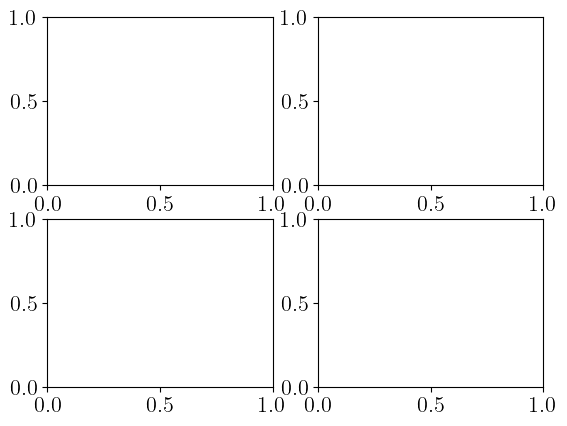

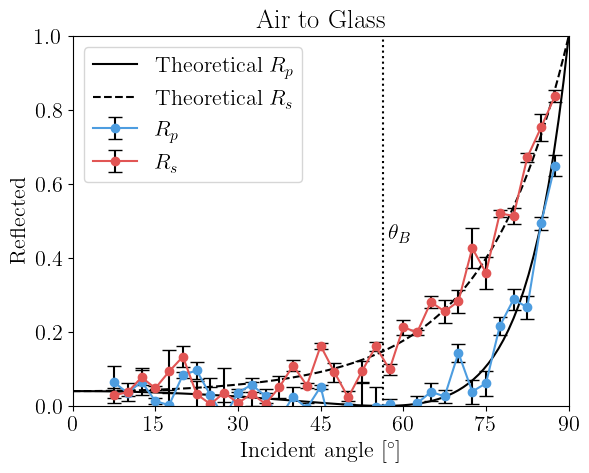

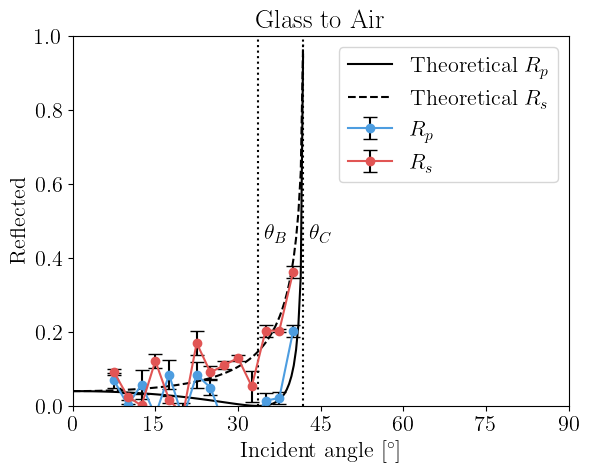

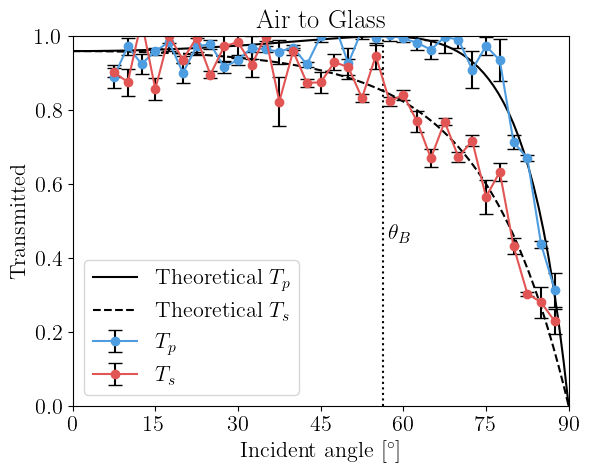

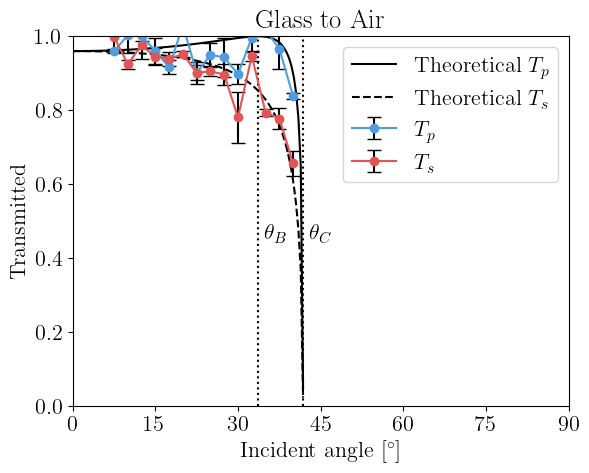

In [114]:
measurement1 = Measurement(air_to_glass_reflected_filename, True, True, (1.76, 1.68), (0.01, 0.02), (1.76, 1.68), (0.01, 0.02))
measurement2 = Measurement(glass_to_air_reflected_filename, True, False, (1.76, 1.68), (0.01, 0.02), (1.76, 1.68), (0.01, 0.02))
measurement3 = Measurement(air_to_glass_transmitted_filename, False, True, (1.76, 1.68), (0.01, 0.02), (1.76, 1.68), (0.01, 0.02))
measurement4 = Measurement(glass_to_air_transmitted_filename, False, False, (1.76, 1.68), (0.01, 0.02), (1.76, 1.68), (0.01, 0.02))
fig, ax = plt.subplots(2, 2)
measurement1.plot(ax[0][0])
measurement2.plot(ax[0][1])
measurement3.plot(ax[1][0])
measurement4.plot(ax[1][1])